# SWIFT SCORE 
## READMISSION PREDICTION
### SWIFT score of greater than 15 is correlated with an increased unplanned readmission risk.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random
from pathlib import Path

In [3]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
PROCESSED_DATA = os.path.join(ROOT_FOLDER , "data", "processed")
ICU_STAYS = os.path.join(PROCESSED_DATA,"icustays_20240512.feather")
df1 = feather.read_feather(ICU_STAYS )
df1 = df1[['icu_stay_id','icu_los','subject_id']]
df1['icu_stay_id'] = df1['icu_stay_id'].astype(int)
df1.head()

,icu_stay_id,icu_los,subject_id
0,31269608,7.702512,10018328
1,37509585,5.452662,10020187
2,32554129,0.872685,10020187
3,31338022,3.766725,10012853
4,32145159,1.037106,10020740


In [4]:
print(os.getcwd()) 

/workspaces/xitaso/reports


In [5]:
os.chdir('/workspaces/xitaso')

In [6]:
from src.data.mimic_iv import hosp

base_path = Path('/workspaces/xitaso/data/external/mimic-iv-2.2')
admissions_df = hosp.build_admissions(base_path=base_path)
print(admissions_df['admission_location'].unique())

['TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY', 'INTERNAL TRANSFER TO OR FROM PSYCH', 'PHYSICIAN REFERRAL', 'EMERGENCY ROOM', 'PACU', 'PROCEDURE SITE', 'WALK-IN/SELF REFERRAL', 'INFORMATION NOT AVAILABLE', 'CLINIC REFERRAL']
Categories (10, object): ['CLINIC REFERRAL', 'EMERGENCY ROOM', 'INFORMATION NOT AVAILABLE', 'INTERNAL TRANSFER TO OR FROM PSYCH', ..., 'PROCEDURE SITE', 'TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY', 'WALK-IN/SELF REFERRAL']


In [7]:
combined_df = pd.merge(admissions_df, df1, on='subject_id', how='left')
combined_df ['admittime'] = pd.to_datetime(combined_df['admittime'])
combined_df ['dischtime'] = pd.to_datetime(combined_df['dischtime'])
combined_df.head()

,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,insurance,language,marital_status,race,edregtime,edouttime,admit_hour_of_day,admit_month,admit_season,ed_los,total_los,icu_stay_id,icu_los
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,14,2,1,0.202778,8.975000,34100191.0,4.952106
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaT,NaT,17,9,3,NaN,7.841667,35258379.0,2.280752
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,2,8,3,0.452083,5.731250,38333427.0,2.110532
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,NaN,UNKNOWN,NaT,NaT,23,11,4,NaN,1.736806,34617352.0,1.751366
4,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,NaN,UNKNOWN,NaT,NaT,23,11,4,NaN,1.736806,32895909.0,0.023727


In [8]:
ICU_TIMESERIES_FEATURES = os.path.join(PROCESSED_DATA,"icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
df2 = feather.read_feather(ICU_TIMESERIES_FEATURES )
df2 = df2[['abs_event_time', 'stay_id','pO2','pCO2','GCS - Eye Opening','O2 Flow','O2 saturation pulseoxymetry','GCS - Motor Response','GCS - Verbal Response']]
df2['abs_event_time'] = pd.to_datetime(df2['abs_event_time'])
df2.head()

,abs_event_time,stay_id,pO2,pCO2,GCS - Eye Opening,O2 Flow,O2 saturation pulseoxymetry,GCS - Motor Response,GCS - Verbal Response
0,1970-01-01 01:00:00,30057454,NaN,NaN,NaN,NaN,93.000000,NaN,NaN
1,1970-01-01 02:00:00,30057454,NaN,NaN,4.0,9.0,94.333333,6.0,5.0
2,1970-01-01 03:00:00,30057454,76.0,45.0,4.0,9.0,95.000000,6.0,5.0
3,1970-01-01 04:00:00,30057454,76.0,45.0,4.0,9.0,94.000000,6.0,5.0
4,1970-01-01 05:00:00,30057454,76.0,45.0,4.0,6.0,92.000000,6.0,5.0


In [9]:
merged_df = pd.merge(combined_df, df2, left_on='icu_stay_id', right_on='stay_id', how='inner')
merged_df.head()

,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,insurance,language,marital_status,race,...,icu_los,abs_event_time,stay_id,pO2,pCO2,GCS - Eye Opening,O2 Flow,O2 saturation pulseoxymetry,GCS - Motor Response,GCS - Verbal Response
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,...,4.952106,1970-01-01 01:00:00,34100191,68.0,47.0,2.0,NaN,94.25,1.0,1.0
1,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,...,4.952106,1970-01-01 02:00:00,34100191,68.0,47.0,2.0,NaN,99.00,1.0,1.0
2,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,...,4.952106,1970-01-01 03:00:00,34100191,191.0,31.0,2.0,NaN,97.00,1.0,1.0
3,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,...,4.952106,1970-01-01 04:00:00,34100191,165.0,29.0,2.0,NaN,98.00,1.0,1.0
4,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,...,4.952106,1970-01-01 05:00:00,34100191,165.0,29.0,2.0,NaN,100.00,1.0,1.0


In [10]:
def calculate_swift_score(row):
    swift_points = 0
    
    # Original source of ICU admission
    if row['admission_location'] == 'EMERGENCY ROOM':
        swift_points += 0
    else:
        swift_points += 8
    
    # Total ICU length of stay
    icu_los = row['icu_los']
    if icu_los < 2:
        swift_points += 0
    elif 2 <= icu_los <= 10:
        swift_points += 1
    elif icu_los > 10:
        swift_points += 14
    
    # Last measured O2 saturation pulseoxymetry
    O2_saturation_pulseoxymetry = row['O2 saturation pulseoxymetry']
    if O2_saturation_pulseoxymetry >= 95:
        swift_points += 0
    elif 95 > O2_saturation_pulseoxymetry < 95:
        swift_points += 5
    elif 90 > O2_saturation_pulseoxymetry <= 90:
        swift_points += 10
    elif O2_saturation_pulseoxymetry < 85:
        swift_points += 13
    
    # Glasgow coma scale at time of ICU discharge
    GCS_Eye_Opening = row['GCS - Eye Opening']
    GCS_Motor_Response = row['GCS - Motor Response']
    GCS_Verbal_Response = row['GCS - Verbal Response']
    glasgow_coma_scale = 15 - (GCS_Eye_Opening + GCS_Motor_Response + GCS_Verbal_Response)
    if glasgow_coma_scale >= 14:
        swift_points += 24
    elif 11 <= glasgow_coma_scale <= 14:
        swift_points += 14
    elif 8 <= glasgow_coma_scale <= 11:
        swift_points += 6
    elif glasgow_coma_scale < 8:
        swift_points += 0
    
    # Last arterial blood gas PaCO2
    pCO2 = row['pCO2']
    if pCO2 <= 45:
        swift_points += 0
    elif pCO2 > 45:
        swift_points += 5
    
    return swift_points

In [11]:
merged_df['SWIFT_score'] = merged_df.apply(calculate_swift_score, axis=1)

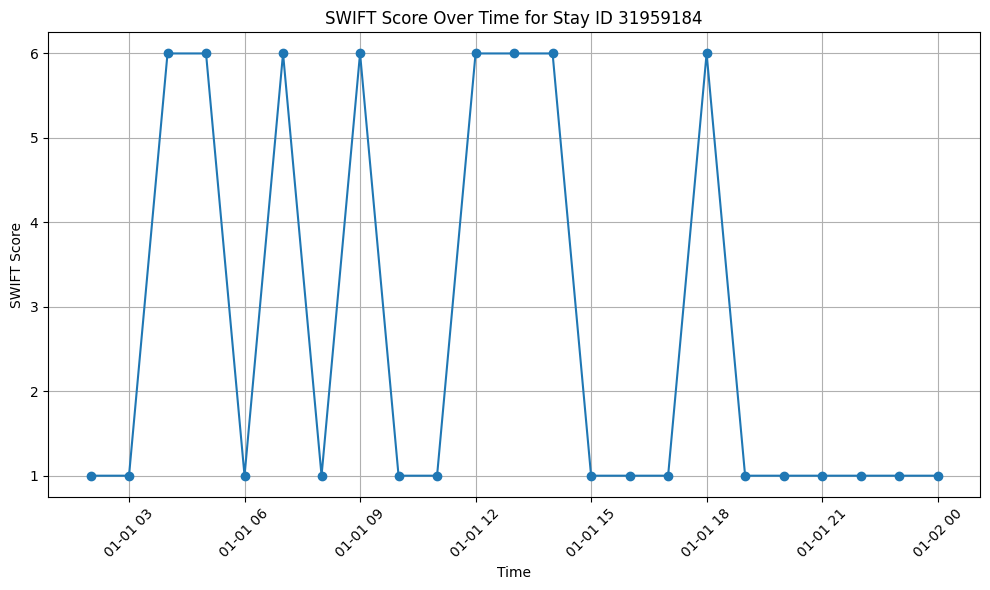

In [12]:
specific_stay_id = 31959184
filtered_data = merged_df[merged_df['stay_id'] == specific_stay_id]

filtered_data.loc[:, 'abs_event_time'] = pd.to_datetime(filtered_data['abs_event_time'])
# SWIFT score
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['abs_event_time'], filtered_data['SWIFT_score'], marker='o')
plt.title(f'SWIFT Score Over Time for Stay ID {specific_stay_id}')
plt.xlabel('Time')
plt.ylabel('SWIFT Score')
plt.grid(True)
plt.xticks(rotation=45)  # Etiketleri daha okunabilir yapmak için
plt.tight_layout()
plt.show()

In [13]:
print(merged_df['stay_id'].unique())

[34100191 35258379 38333427 34617352 32895909 35544374 32604416 39268883
 36753294 38430513 34324099 34531557 36091287 32496174 36734659 32145159
 35889503 31077365 35044342 35026312 33383124 38017367 37200209 34600477
 39864867 38559363 37323533 39553978 33683112 36084484 34499716 39544395
 38137964 37093652 38587181 37507305 34577403 32128372 30955999 38554095
 30057454 37127068 39061571 39084876 37049133 35629889 31921355 39635619
 36558922 38329661 33177122 34629895 32283063 35065627 35679826 30932571
 34107647 35727289 35214014 38507547 36107367 33558396 31248398 38229329
 32506122 36427705 30849778 35475449 37267577 35436337 39492446 33083787
 31205490 37067082 34592300 33846653 35024147 30757476 32453351 30101877
 32119961 34170353 32374504 30665396 35128235 38907302 31959184 30585761
 32166508 33652203 30913302 30864406 31552399 39804682 35396193 31338022
 34578020 35446858 32155744 36035031 39543480 36871784 39711498 35636875
 32314488 30425410 37057036 31494479 36059427 35146